In [ ]:
from scipy import sparse
from bluepysnap import Circuit
from graph_analysis.randomize import WeightPermutedRandomModel
from graph_analysis.rich_cub import RichClubAnalysis
from dask.distributed import Client, LocalCluster
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm

In [121]:
file_format = 'png'
dpi = 300
save_dir = '../output/rich_club'

In [ ]:
adj_path = '/gpfs/bbp.cscs.ch/project/proj112/circuits/CA1/20211110-BioM/data/ca1_synaptome.npz'
synaptome = sparse.load_npz(adj_path)
connectome = synaptome.copy()
connectome[connectome > 0] = 1
# del synaptome

target = 'slice10'
CIRCUIT_DIR =  '/gpfs/bbp.cscs.ch/project/proj112/circuits/CA1/20211110-BioM/sonata/circuit_config.json'
circuit = Circuit(CIRCUIT_DIR)
nodes = circuit.nodes["hippocampus_neurons"]
edges = circuit.edges["hippocampus_neurons__hippocampus_neurons__chemical_synapse"]
target_indices = nodes.ids(target)
target_synaptome = synaptome[target_indices,:][:,target_indices]
target_connectome = connectome[target_indices,:][:,target_indices]

In [ ]:
# del target_synaptome, target_connectome

In [ ]:
# model_dp = WeightPermutedRandomModel(target_synaptome)

# random_adjs = []

# for i in tqdm(range(100)):
#     dp_adj = model_dp.generate(seed=i)
#     random_adjs.append(dp_adj)

In [ ]:
# calculate the rich club coefficients for the original graph
rca_syn = RichClubAnalysis(target_synaptome)
client = Client()    # Start Dask client
k_dict_parallel_model = rca_syn.calculate_rich_club_coefficients(weighted=True,
                            method='strongest-links-in-network',step=100)
client.shutdown()    # Shutdown the Dask client

In [ ]:
original_coeffs = pd.DataFrame.from_dict(k_dict_parallel_model, orient='index').T
# original_coeffs.to_csv(f'../output/rich_club/weigted_rcc_{target}.csv')

In [22]:
original_coeffs = pd.read_csv('../output/rich_club/weigted_rcc_slice10.csv',index_col=0)

In [48]:
output_dir = '../output/rich_club/'
random_rc_coeffs = pd.read_csv(f'{output_dir}/random_rc_coeffs.csv',index_col=0)
average_random_coeffs = np.mean(random_rc_coeffs, axis=0).to_frame().T

In [ ]:
normalized_coeffs = original_coeffs.values[:,:average_random_coeffs.shape[1]] / average_random_coeffs.values

In [ ]:
normalized_rc_df = pd.DataFrame(normalized_coeffs,columns=average_random_coeffs.columns).T

In [ ]:
f ,ax= plt.subplots()
x= np.array(normalized_rc_df.index).astype(float).astype(int)
ax.plot(x, normalized_rc_df.values.flatten(), label='Data')
ax.fill_between(x, normalized_rc_df.values.flatten(), y2=1, where=(normalized_rc_df.values.flatten() >= 1), color='lightblue', alpha=0.4)
ax.axhline(y=1, color='k', linestyle='--', label='y=1')

plt.title('Weighted Rich Club Coefficients (n=100)')
plt.xlabel('k (total_degree: weight)')
plt.ylabel('Coefficient')
plt.legend(['norm_RC_coeff'])
plt.savefig(f"../output/rich_club_weigted_{target}.png", dpi=dpi, bbox_inches='tight')

In [ ]:
plt.plot(random_rc_coeffs.values.mean(axis=0).flatten())
plt.plot(original_coeffs.values.flatten())

In [4]:
# generate er and dd as well

from graph_analysis.randomize import DistanceDependentConfigurationalModel, ErdosRenyiModel
from graph_analysis.rich_cub import RichClubAnalysis

In [5]:
xyz = nodes.get(target)[['x','y','z']]

er_generator = ErdosRenyiModel(target_synaptome)
# model = BarabasiAlbertModel(adj)
# model = WattsStrogatzModel(adj)
# model = ConfigurationModel(adj)
# model = DistanceDependentConfigurationalModel(target_synaptome,xyz)

dd_generator = DistanceDependentConfigurationalModel(target_synaptome,xyz)

In [6]:
num_syns_per_conn = target_synaptome.sum() / target_synaptome.count_nonzero()
num_syns_per_conn = np.round(num_syns_per_conn).astype(int)

In [7]:
er1 = er_generator.generate()
er1 *= num_syns_per_conn
dd_model = dd_generator.generate().astype(int)
dd_weights = np.random.random(dd_model.data.shape[0]) * num_syns_per_conn
dd_model.data = dd_weights

12615it [00:05, 2128.34it/s]


In [8]:
inh_indices = np.where(nodes.get(target).morph_class=='INT')[0]
exc_indices = np.where(nodes.get(target).morph_class=='PYR')[0]

In [9]:
num_syns_per_conn = target_synaptome.sum() / target_synaptome.count_nonzero()
num_syns_per_conn = np.round(num_syns_per_conn).astype(int)

In [10]:
ee_spc = target_synaptome[exc_indices,:][:,exc_indices].sum() / target_synaptome[exc_indices,:][:,exc_indices].count_nonzero()
ei_spc = target_synaptome[exc_indices,:][:,inh_indices].sum() / target_synaptome[exc_indices,:][:,inh_indices].count_nonzero()
ie_spc = target_synaptome[inh_indices,:][:,exc_indices].sum() / target_synaptome[inh_indices,:][:,exc_indices].count_nonzero()
ii_spc = target_synaptome[inh_indices,:][:,inh_indices].sum() / target_synaptome[inh_indices,:][:,inh_indices].count_nonzero()

In [11]:
print(f'EE:{ee_spc},\nEI:{ei_spc},\nIE:{ie_spc},\nII:{ii_spc}')

EE:1.3327996206466048,
EI:6.355439853452315,
IE:11.538668999442502,
II:5.425033354635453


In [12]:
def density(arr):
    if arr.shape[0] == arr.shape[1]:
        return arr.count_nonzero() / (arr.shape[0]*(arr.shape[1]-1))
    else:
        return arr.count_nonzero() / (arr.shape[0]*(arr.shape[1]))
    
ee_dens =  density(target_synaptome[exc_indices,:][:,exc_indices])
ei_dens =  density(target_synaptome[exc_indices,:][:,inh_indices])
ie_dens = density(target_synaptome[inh_indices,:][:,exc_indices])
ii_dens =  density(target_synaptome[inh_indices,:][:,inh_indices])

In [13]:
er_ee = sparse.random(len(exc_indices), len(exc_indices), density=ee_dens, format='csr') * ee_spc
er_ei = sparse.random(len(exc_indices), len(inh_indices), density=ei_dens, format='csr') * ei_spc
er_ie = sparse.random(len(inh_indices), len(exc_indices), density=ie_dens, format='csr') * ie_spc
er_ii = sparse.random(len(inh_indices), len(inh_indices), density=ii_dens, format='csr') * ii_spc

In [15]:
sbm = sparse.vstack([sparse.hstack([er_ee,er_ei]),sparse.hstack([er_ie,er_ii])])

In [16]:
rca_dd = RichClubAnalysis(dd_model)
rca_er = RichClubAnalysis(er1)
# rca_sbm = RichClubAnalysis(sbm)

client = Client()    # Start Dask client
k_dict_parallel_dd = rca_dd.calculate_rich_club_coefficients(weighted=True,
                                                            method='strongest-links-in-network',
                                                            scheduler=None,
                                                            step=100)
k_dict_parallel_er = rca_er.calculate_rich_club_coefficients(weighted=True,
                                                            method='strongest-links-in-network',
                                                            scheduler=None,
                                                            step=100)
k_dict_parallel_sbm = rca_sbm.calculate_rich_club_coefficients(weighted=True,
                                                            method='strongest-links-in-network',
                                                            scheduler=None,
                                                            step=100)
client.shutdown()    # Shutdown the Dask client

2023-07-11 15:53:42,126 - distributed.diskutils - INFO - Found stale lock file and directory '/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/kurban/1616884/dask-worker-space/worker-b5yeyhqw', purging
2023-07-11 15:53:42,128 - distributed.diskutils - INFO - Found stale lock file and directory '/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/kurban/1616884/dask-worker-space/worker-lz84_nvv', purging
2023-07-11 15:53:42,128 - distributed.diskutils - INFO - Found stale lock file and directory '/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/kurban/1616884/dask-worker-space/worker-cz7krjzf', purging
2023-07-11 15:53:42,129 - distributed.diskutils - INFO - Found stale lock file and directory '/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/kurban/1616884/dask-worker-space/worker-fulq6yfg', purging
2023-07-11 15:53:42,129 - distributed.diskutils - INFO - Found stale lock file and directory '/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/kurban/1616884/dask-worker-space/worker-1vd1p7_c', purging
2023-07-11 15:53:42,130 - distributed.diskutils - INFO - Found stale l

NameError: name 'rca_sbm' is not defined

In [20]:
rca_sbm = RichClubAnalysis(sbm)

client = Client()    # Start Dask client
k_dict_parallel_sbm = rca_sbm.calculate_rich_club_coefficients(weighted=True,
                                                            method='strongest-links-in-network',
                                                            scheduler=None,
                                                            step=100)
client.shutdown()    # Shutdown the Dask client

INFO:distributed.worker:Stopping worker at tcp://127.0.0.1:34797. Reason: nanny-close
INFO:distributed.core:Connection to tcp://127.0.0.1:43056 has been closed.


In [82]:
original_coeffs_dict = {k: v['slice'] for k, v in original_coeffs.T.to_dict('index').items()}
dp_coeffs_dict = {k: v[0] for k, v in average_random_coeffs.T.to_dict('index').items()}

In [116]:
keys_list = [float(key) for key in dp_coeffs_dict.keys()]
keys_list = np.array(keys_list).astype(int)

keys_list_ca1 = [float(key) for key in original_coeffs_dict.keys()]
keys_list_ca1 = np.array(keys_list_ca1).astype(int)

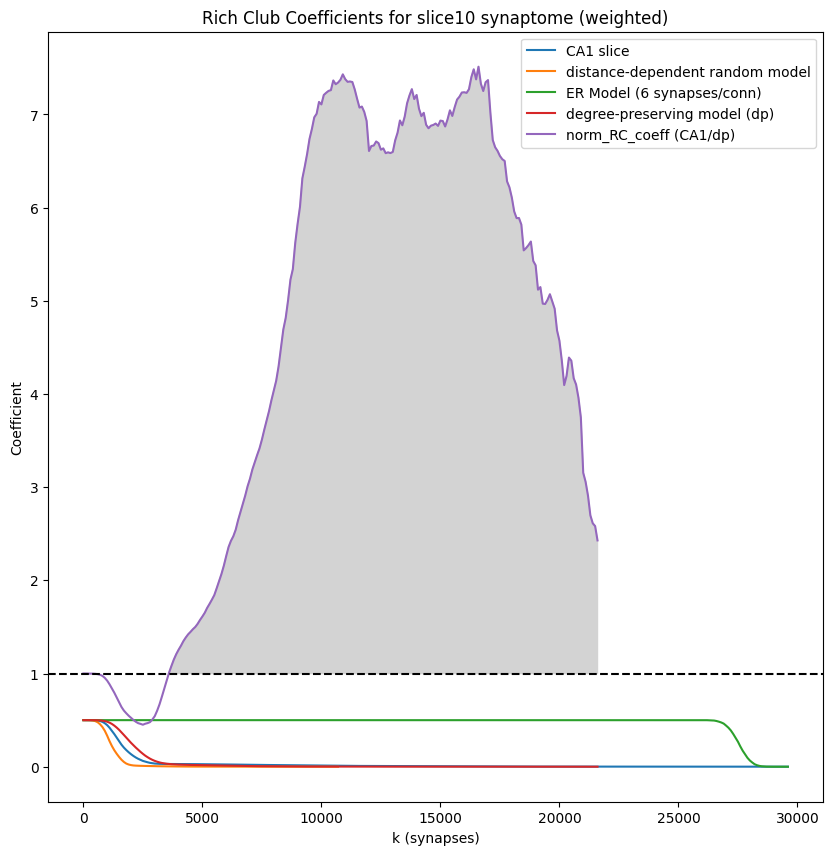

In [122]:
f ,ax= plt.subplots(figsize=(10,10))

plt.plot(keys_list_ca1,original_coeffs_dict.values())
plt.plot(k_dict_parallel_dd.keys(),k_dict_parallel_dd.values())
plt.plot(k_dict_parallel_er.keys(),k_dict_parallel_er.values())
plt.plot(keys_list,dp_coeffs_dict.values())

random_vals = np.array(list(dp_coeffs_dict.values()))
norm_rc = np.array(list(original_coeffs_dict.values()))[:random_vals.shape[0]] / random_vals
plt.plot(keys_list,norm_rc)
ax.axhline(y=1, color='k', linestyle='--', label='y=1')
ax.fill_between(keys_list, norm_rc, 1, where=(np.array(norm_rc) >= 1), color='lightgray')

plt.title('Rich Club Coefficients for slice10 synaptome (weighted)')
plt.xlabel('k (synapses)')
plt.ylabel('Coefficient')
plt.legend(['CA1 slice',
            'distance-dependent random model',
            'ER Model (6 synapses/conn)',
            'degree-preserving model (dp)',
            'norm_RC_coeff (CA1/dp)'])
plt.savefig(f"{save_dir}/rich_club_directed_weighted.png", dpi=dpi, bbox_inches='tight')

In [120]:
!ls ../output

common_neighbors		 spectral_analysis
degree_and_polarity		 spectral_analysis_test
information_flow		 spectral_clustering_3d.png
random_models			 spectral_clustering.png
rich_club			 synaptome_cylinder_with_proj.png
rich_club_directed_weighted.png  triplets
rich_club_weigted_slice10.png


# Statistical Tests

I didnt see a 

In [ ]:
u_stat, p_val = stats.mannwhitneyu(random_rc_coeffs.values, 
                                   original_coeffs.values[:,:random_rc_coeffs.shape[1]], alternative='two-sided')


print(f"U statistic: {u_stat}")
print(f"P-value: {p_val}")

# interpret the result
alpha = 0.05  # significance level
if p_val < alpha:
    print("The rich-club coefficient of the original graph is significantly different from the coefficients of the randomized graphs.")
else:
    print("There is not enough evidence to suggest that the rich-club coefficient of the original graph is significantly different from the coefficients of the randomized graphs.")


In [ ]:
np.where(p_val < alpha)

In [ ]:
from scipy import stats

# aligned_arr1 = np.repeat(original_coeffs.values[:,:random_rc_coeffs.shape[1]], random_rc_coeffs.shape[0], axis=0)
control_data_mean = np.nanmean(random_rc_coeffs.values, axis=0).reshape(1,217)

t_statistic, p_value = stats.ttest_1samp(original_coeffs.values[:,:random_rc_coeffs.shape[1]], 
                                         control_data_mean,
                                         nan_policy='omit'
                                         )

print('Statistical Test Results:')
print('T-Statistic:', t_statistic)
print('P-Value:', p_value)

<!-- # Use Dask to distribute among slurm nodes -->

In [ ]:
# from dask_jobqueue import SLURMCluster
# import os

# def calculate_rich_club_coefficients(target_synaptome, seed):
#     model_dp = WeightPermutedRandomModel(target_synaptome)
#     dp_adj = model_dp.generate(seed=seed)

#     rca_dp = RichClubAnalysis(dp_adj)
#     k_dict_parallel_dp = rca_dp.calculate_rich_club_coefficients(weighted=True,
#                             method='strongest-links-in-network',step=100)
#     return k_dict_parallel_dp.values()

# n_trials = 5

# # setup SLURM cluster
# random_type = 'WP'
# cluster = SLURMCluster(queue='prod', 
#                        cores=4,
#                        name=f'rich_club_{random_type}',
#                        log_directory = f'{os.getcwd()}/slurm_logs/',
#                        memory="32GB", 
#                        walltime='01:00:00',
#                        account='proj112',
# #                       job_script="/gpfs/bbp.cscs.ch/project/proj112/home/kurban/topology_paper/toolbox/graph_analysis/notebooks/dask_worker.sbatch",
#                       )

# client = Client(cluster)

# # adjust the scale to match the number of trials (this might vary depending on your setup)
# cluster.scale(n_trials)  
# futures = client.map(calculate_rich_club_coefficients, [target_synaptome]*n_trials, range(n_trials))
# results = client.gather(futures)